### Create network

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import igraph as ig
from statistics import mean

In [8]:
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', str)

In [9]:
def _random_subset(seq, m, rng):
    """Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.

    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

In [10]:
# from networkx source code, amended
def barabasi_albert_graph(n, m, seed=None, initial_graph=None):
    """Returns a random graph using Barabási–Albert preferential attachment

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    initial_graph : Graph or None (default)
        Initial network for Barabási–Albert algorithm.
        It should be a connected graph for most use cases.
        A copy of `initial_graph` is used.
        If None, starts from a star graph on (m+1) nodes.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``, or
        the initial graph number of nodes m0 does not satisfy ``m <= m0 <= n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási–Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = nx.star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási–Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = [n for n, d in G.in_degree() for _ in range(d)]
    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:
        # print(source)
        # print("source")
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes + list(G.nodes), m, seed) # add +list(G.nodes) so that also 0-in.degree nodes "could" get sampled
        #print(repeated_nodes + list(G.nodes))
        #print("targets")
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        #print("add edges")
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
    
        #print(repeated_nodes)
        #print("add target nodes to repeated lists")
        # And the new node "source" has m edges to add to the list.
        
        # repeated_nodes.extend([source] * m) # Laura: comment out so outgoing degree is not reflected in preferential sampling from repeated nodes 

        source += 1
    return G

### Generate synthetic Barabasi-Albert directed networks for simulations

In [11]:
for i in list(range(0,5000,1)):
    np.random.seed(i)
    rng = np.random.default_rng() 
    import random
    random.seed(i)        # or any integer
    
    m = 3
    size = 1000 # number of nodes   

    # Initial network to be fed into amended BA-function
    D = nx.complete_graph(m, nx.DiGraph())
    # D.degree
    G = barabasi_albert_graph (size, m, rng, D)
    #nx.draw(G, with_labels=True)   
    # Check avergae clustering coefficient and average out-degree
    G_edgelist = nx.generate_edgelist(G) # to create new undirected graph to compute clustering coeff 
    G_undir = nx.parse_edgelist(G_edgelist)

    goalcoeff = .29 # retrieved from empirical data, see below
    clustercoeff = nx.average_clustering(G_undir)

    while clustercoeff < goalcoeff:
        # 0 sample source node
        source = random.sample(G.nodes,1)[0]    
        
        # 1 sample 1 friend of source node
        if G.out_degree(source) > 1:  # only edges originating from these nodes: outgoing edges: befriending
            friend_of_source = random.sample([n for n in G.neighbors(source)],1)[0]
        else: 
            friend_of_source = [n for n in G.neighbors(source)][0]
        
        # 2 sample a friend of the friend, not source
        if G.out_degree(friend_of_source) > 1:
            friend_of_friend = random.sample([n for n in G.neighbors(friend_of_source)],1)[0]
        else: 
            friend_of_friend = [n for n in G.neighbors(friend_of_source)][0]
        
        # 3 add edge from the friend's friend to source node (if not source node chosen)
        if source != friend_of_friend:
            G.add_edge(source,friend_of_friend, color='r')
        
            G_edgelist = nx.generate_edgelist(G)
            G_undir = nx.parse_edgelist(G_edgelist)
            clustercoeff = nx.average_clustering(G_undir)
    
    network_name = f'networks/NW_{i}.gml'
    nx.write_gml(G, network_name)
        

/var/folders/0h/1n_j20xj2zzg446ph069f1z00000gn/T/ipykernel_90015/1257885152.py:24: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  source = random.sample(G.nodes,1)[0]


KeyboardInterrupt: 

##### In/Out Degree distribution

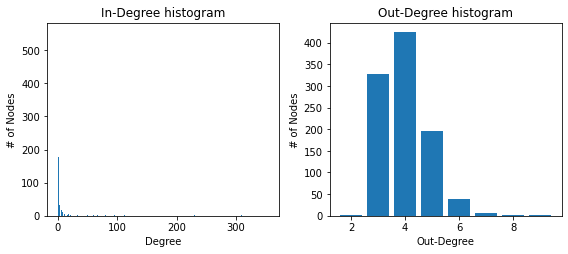

In [36]:
# In- and Out-Degree distribution

in_degree_sequence = sorted((d for n, d in G.in_degree()), reverse=True)
out_degree_sequence = sorted((d for n, d in G.out_degree()), reverse=True)

dmax = max(in_degree_sequence)


fig = plt.figure("In- and Out-Degree of our directed BA-graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.bar(*np.unique(in_degree_sequence, return_counts=True))
ax1.set_title("In-Degree histogram")
ax1.set_ylabel("# of Nodes")
ax1.set_xlabel("Degree")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(out_degree_sequence, return_counts=True))
ax2.set_title("Out-Degree histogram")
ax2.set_xlabel("Out-Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [16]:
#F = nx.DiGraph()
#F.add_edges_from(([1, 2],[4, 5],[6,4],[2,4],[3,2],[5,1]),color='black')
#edges = F.edges()        
#colors = [F[u][v]['color'] for u,v in edges]
#nx.draw(F, with_labels=True, edge_color=colors)

In [17]:
#F_edgelist = nx.generate_edgelist(F)
#F_undir = nx.parse_edgelist(F_edgelist)
#nx.average_clustering(F_undir)

In [30]:
#edges = G.edges()        
#colors = [G[u][v]['color'] for u,v in edges]
#x.draw(G, with_labels=True, edge_color=colors)

In [37]:
nx.average_clustering(G_undir)

0.29024197325515416

In [38]:
sum([d for (n, d) in G.out_degree()]) / float(G.number_of_nodes())

3.971

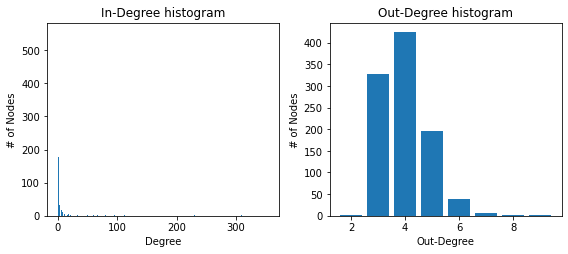

In [39]:
# In- and Out-Degree distribution

in_degree_sequence = sorted((d for n, d in G.in_degree()), reverse=True)
out_degree_sequence = sorted((d for n, d in G.out_degree()), reverse=True)

dmax = max(in_degree_sequence)


fig = plt.figure("In- and Out-Degree of our directed BA-graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.bar(*np.unique(in_degree_sequence, return_counts=True))
ax1.set_title("In-Degree histogram")
ax1.set_ylabel("# of Nodes")
ax1.set_xlabel("Degree")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(out_degree_sequence, return_counts=True))
ax2.set_title("Out-Degree histogram")
ax2.set_xlabel("Out-Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [40]:
# Density of network
nx.density(G)

0.003974974974974975

##### Retrieve goal values/metrics from epirical network

In [34]:
Emp = nx.read_gml("/Users/laurajahn/Documents/Git/Follower network for marketplace/follower_network.gml", destringizer=int)

In [35]:
file = "/Users/laurajahn/Documents/Git/Follower network for marketplace/follower_network.gml"
def read_empirical_network(file):
    # print('File: ', file)
    net = ig.Graph.Read_GML(file)
    
    #prevent errors with duplicate attribs
    net = _delete_unused_attributes(net, desire_attribs=['label', 'party', 'misinfo'])
    return net 

def _delete_unused_attributes(net, desire_attribs=['uid','party', 'misinfo']):
    #delete unused attribs or artifact of igraph to maintain consistency
    for attrib in net.vs.attributes():
        if attrib not in desire_attribs:
            del(net.vs[attrib])
    return net 

In [36]:
Emp = read_empirical_network(file)

In [37]:
ig.summary(Emp)

IGRAPH D--- 10006 1809798 -- 
+ attr: label (v), misinfo (v), party (v)


In [38]:
max(Emp.degree())

3857

##### In- and Out Degree distribution

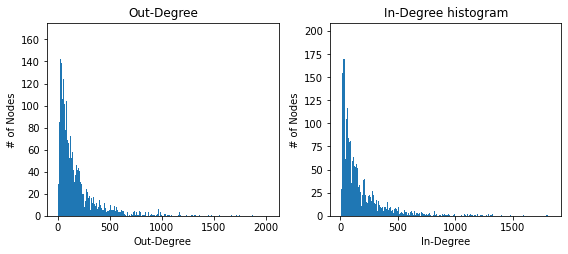

In [39]:
fig = plt.figure("In- and Out-Degree", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax1 = fig.add_subplot(axgrid[3:, :2])
bins = 1000
ax1.hist(Emp.outdegree(), bins)
ax1.set_title("Out-Degree")
ax1.set_ylabel("# of Nodes")
ax1.set_xlabel("Out-Degree")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.hist(Emp.indegree(), bins)
ax2.set_title("In-Degree histogram")
ax2.set_xlabel("In-Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

##### Average out/in degree

In [40]:
mean(Emp.outdegree())

180.8712772336598

In [41]:
# treat directed emp network as undirected to calculate avergae clustering coefficient
type(Emp)
Emp_nx_edgelist = Emp.get_edgelist()
Emp_nx = nx.Graph(Emp_nx_edgelist)

##### Transitivity

In [42]:
# NETWORKX PACKAGE
# print(nx.triangles(G))  # not implemented for directed type 
print(nx.transitivity(Emp_nx)) # Compute graph transitivity, the fraction of all possible triangles present in G. #Possible triangles are identified by the number of “triads” (two edges with a shared vertex).

0.20350813879974466


In [43]:
# IGRAPH PACKAGE
# Transitivity (average clustering coeff) 
Emp.transitivity_undirected()

0.20350813879974466

##### Average clustering coefficient

In [44]:
# NETWORKX PACKAGE
format(nx.average_clustering(Emp_nx), 'f')

'0.293209'